In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, Input, BatchNormalization, Dropout, Dense, Flatten, Lambda
from keras.models import Model, Sequential
import keras.backend as K
from tensorflow.keras.utils import plot_model

from scipy.spatial.distance import cosine

### Image Similarity using Contrastive Learning

The idea behind Contrastive Learning is based on **discrimination**, to differentiate similar examples from non-similar examples. In this notebook, we will model a NN on MNIST dataset such that it differentiates similar digits from non-similar digits. Contrastive Learning is a powerful technique in the realm of **Self-Supervised Learning**.

The loss function that we will consider is **Triplet Loss** which tries to minimize the distance between anchor and positive sample while maximizing distance between anchor and negative sample where anchor and positive sample are images of a random digit while negative sample is image of any digit different from that digit.

Since we will be comparing representations using Triplet Loss, it is important that the representations are in common space. In case if different networks are being created (say where one anchor is text and positive and negative sample is image, in a case of multi-modal learning), there needs to be a final layer/model with weights shared in order to bring all these entities in common space such that they can be compared.

In our case, as all three entities are images, we will create a single model to get representations. However, we could also have Siamese Networks with final projection layer as per use case.

In [2]:
sample_pct = 0.1
img_size = 28

n_epochs = 30
learning_rate = 1E-6
batch_size = 128

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
def make_triplets(X, y):
    triplets = []
    num_examples = int(sample_pct * len(X))

    for _ in range(num_examples):
        digit_selected = np.random.choice(digits)

        # get positive examples
        idxs = np.where(y==digit_selected)[0]
        idx1, idx2 = np.random.choice(idxs, 2, replace=False)

        # get negative examples
        idxs = np.where(y!=digit_selected)[0]
        idx3 = np.random.choice(idxs, 1)[0]
        triplets.append([X[idx1], X[idx2], X[idx3]])

    triplets = np.array(triplets)
    return triplets

digits = list(range(10))

triplets = make_triplets(X_train, y_train)    
test_triplets = make_triplets(X_test, y_test) 
print('Number of training triplets:', len(triplets))
print('Number of testing triplets:', len(test_triplets))

Number of training triplets: 6000
Number of testing triplets: 1000


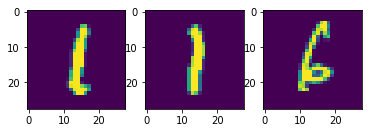

In [5]:
idx = np.random.choice(len(test_triplets), 1)[0]
plt.subplot(131)
plt.imshow(triplets[idx][0])

plt.subplot(132)
plt.imshow(triplets[idx][1])

plt.subplot(133)
plt.imshow(triplets[idx][2])
plt.show()

In [6]:
def featurizer(img_size):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2,2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.build(input_shape = (None, img_size, img_size, 1))
    return model 

def euclidean_distance(vecs):
    anc, pos, neg = vecs
    ap_distance = K.sqrt(K.sum(K.square(anc - pos), axis=1))
    an_distance = K.sqrt(K.sum(K.square(anc - neg), axis=1))
    return ap_distance, an_distance    

In [7]:
anc_inp = Input(shape=(img_size, img_size, 1))
pos_inp = Input(shape=(img_size, img_size, 1))
neg_inp = Input(shape=(img_size, img_size, 1))

# get embeddings
# common model - weights shared
proj_model = featurizer(img_size)
anc_emb = proj_model(anc_inp)
pos_emb = proj_model(pos_inp)
neg_emb = proj_model(neg_inp)

# compare embeddings
distances = Lambda(euclidean_distance, name='lambda')([anc_emb, pos_emb, neg_emb])

model = Model(inputs = [anc_inp, pos_inp, neg_inp], outputs = distances)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 512)          1188832     ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

2022-05-29 02:51:26.994086: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


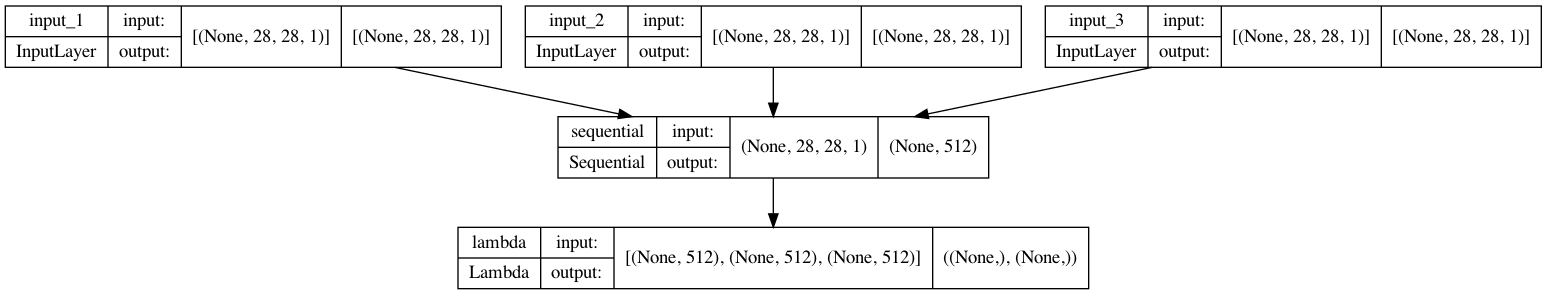

In [8]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
def triplet_loss(y_true, y_pred):
    ap_distance, an_distance = y_pred[0], y_pred[1]
    loss = ap_distance - an_distance
    loss = tf.maximum(loss, 0)
    loss = tf.reduce_mean(loss)
    return loss    

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=triplet_loss, optimizer=optimizer, metrics=None)

anc = triplets[:,0,:,:]
pos = triplets[:,1,:,:]
neg = triplets[:,2,:,:]
y = np.zeros(anc.shape[0])

history = model.fit([anc, pos, neg], y, epochs = n_epochs, shuffle = True, batch_size=batch_size, 
                    validation_split = 0.2, verbose=1)

Epoch 1/30
38/38 [==============================] - 9s 206ms/step - loss: 9.9472 - lambda_loss: 5.1828 - lambda_1_loss: 4.7644 - val_loss: 6.3127 - val_lambda_loss: 6.0724 - val_lambda_1_loss: 0.2403
Epoch 2/30
38/38 [==============================] - 7s 197ms/step - loss: 5.9206 - lambda_loss: 3.0927 - lambda_1_loss: 2.8279 - val_loss: 5.7964 - val_lambda_loss: 5.5874 - val_lambda_1_loss: 0.2090
Epoch 3/30
38/38 [==============================] - 8s 199ms/step - loss: 6.2299 - lambda_loss: 3.3421 - lambda_1_loss: 2.8877 - val_loss: 5.6982 - val_lambda_loss: 5.5043 - val_lambda_1_loss: 0.1940
Epoch 4/30
38/38 [==============================] - 7s 197ms/step - loss: 11.2808 - lambda_loss: 6.0060 - lambda_1_loss: 5.2748 - val_loss: 5.6799 - val_lambda_loss: 5.4942 - val_lambda_1_loss: 0.1857
Epoch 5/30
38/38 [==============================] - 8s 199ms/step - loss: 8.3440 - lambda_loss: 5.5695 - lambda_1_loss: 2.7745 - val_loss: 5.6702 - val_lambda_loss: 5.4875 - val_lambda_1_loss: 0.1827

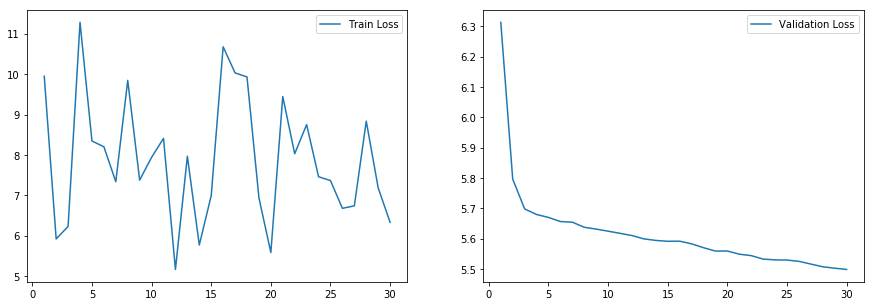

In [10]:
def plotting(train_loss, val_loss):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(1, n_epochs+1), train_loss, label = 'Train Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(range(1, n_epochs+1), val_loss, label = 'Validation Loss')
    plt.legend()

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)    

In [11]:
test_anc = test_triplets[:,0,:,:]
test_pos = test_triplets[:,1,:,:]
test_neg = test_triplets[:,2,:,:]

# distance between anc-pos example should be less than anc-neg example 
ap_distance, an_distance = model.predict([test_anc, test_pos, test_neg])
np.mean(ap_distance), np.mean(an_distance)

(39.405163, 46.213257)

In [12]:
test_anc_emb = proj_model(test_anc).numpy()
test_pos_emb = proj_model(test_pos).numpy()
test_neg_emb = proj_model(test_neg).numpy()

In [13]:
def get_cosine_distances(idx, test_anc_emb, test_pos_emb, test_neg_emb):
    anc = test_anc_emb[idx]
    pos = test_pos_emb[idx]
    neg = test_neg_emb[idx]

    return cosine(anc, pos), cosine(anc, neg)

idx = 5
get_cosine_distances(idx, test_anc_emb, test_pos_emb, test_neg_emb)

(0.34093785285949707, 0.4831010103225708)

### Observations

1. We can notice that the mean distance between anchor and positive sample is lesser than anchor and negative sample.
2. For any random example, we can notice that the cosine distance between anchor and positive sample is lesser than anchor and negative sample.